In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import mediapipe as mp

# Keypoints using MP Holistic

In [2]:
# Initialize Mediapipe Holistic model
mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

In [3]:
def mediapipe_detection(image, model):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = model.process(image_rgb)
    image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
    return image_bgr, results

In [15]:
def draw_landmarks(image, results):
    # Colors for drawing
    color_face = mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1)
    color_face_connection = mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1)
    color_hand = mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4)
    color_pose = mp_drawing.DrawingSpec(color=(245, 117, 66), thickness=2, circle_radius=2)

    # Draw the landmarks
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS,
                                      color_face, color_face_connection)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, color_hand)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS, color_pose)

In [30]:
def capture_video():
    cap = cv2.VideoCapture(0)
    results_list = []

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            success, image = cap.read()
            if not success:
                break

            # Pass the frames through the model
            image_bgr, results = mediapipe_detection(image, holistic)

            # Draw landmarks on the frames
            draw_landmarks(image_bgr, results)

            # Store the results
            results_list.append(results)

            # Display the image
            cv2.imshow('Real-Time Object Detection with Landmarks', image_bgr)

            # Check for 'q' key press to exit
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

    cap.release()
    cv2.destroyAllWindows()
    return image_bgr, results_list


In [31]:
image, results_list = capture_video()

c:\Users\samer\anaconda3\envs\samerenv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [28]:
draw_landmarks(image, results_list[-1])

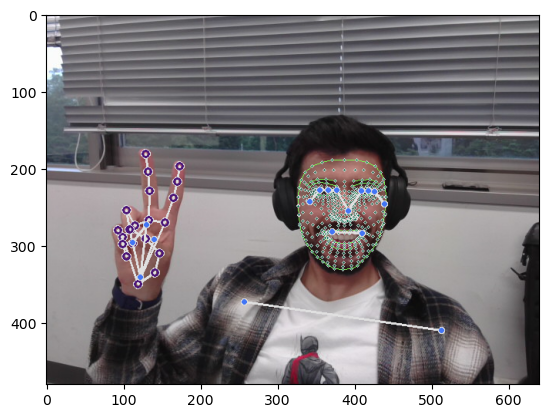

In [29]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Extract the Keypoint Values